<a href="https://colab.research.google.com/github/MRsources/MRzero-Core/blob/main/documentation/playground_mr0/mr0_DREAM_STID_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pypulseq &> /dev/null
!pip install MRzeroCore &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

In [ ]:
# @title On Google Colab, you need to restart the runtime after executing this cell
!pip install numpy==1.24

(DREAM_STID_seq)=
# STID - DREAM

This is a pulseq implementation of the single slice DREAM sequence [1] using the STID first (STE* first) timing scheme and thus enabling the mapping of B1.

Also a B0 map is reconstructed here, but due to the timing, it is zero as expected.

---

[1] Nehrke, K., Versluis, M.J., Webb, A. and Börnert, P. (2014), Volumetric B1+ Mapping of the Brain at 7T using DREAM. Magn. Reson. Med., 71: 246-256. https://doi.org/10.1002/mrm.24667

/usr/local/lib/python3.10/dist-packages/sigpy/config.py:15: UserWarning: Importing cupy failed. For more details, see the error stack below:

Failed to import CuPy.

If you installed CuPy via wheels (cupy-cudaXXX or cupy-rocm-X-X), make sure that the package matches with the version of CUDA or ROCm installed.

On Linux, you may need to set LD_LIBRARY_PATH environment variable depending on how you installed CUDA/ROCm.
On Windows, try setting CUDA_PATH environment variable.

Check the Installation Guide for details:
  https://docs.cupy.dev/en/latest/install.html

Original error:
  ImportError: libcuda.so.1: cannot open shared object file: No such file or directory

  warnings.warn(


Set bandwidth to 1041.6666666666667Hz/pixel
Timing check passed successfully


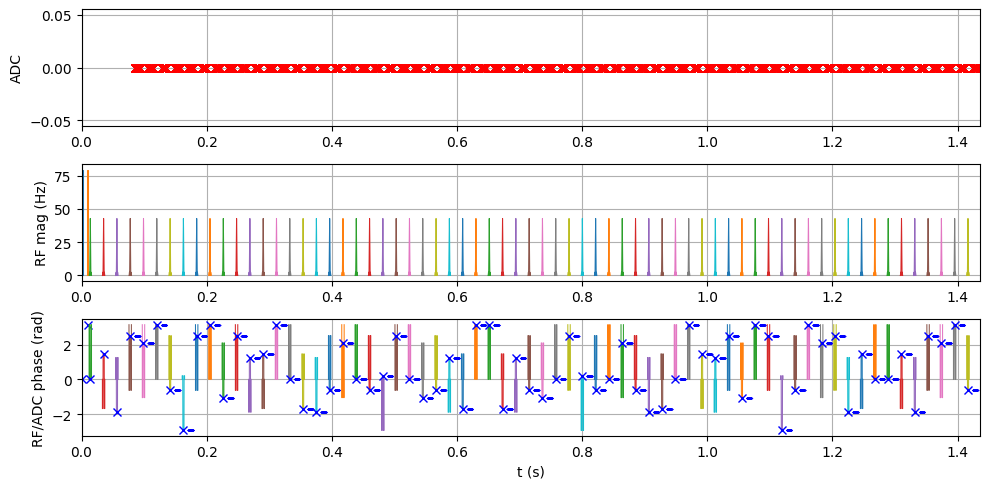

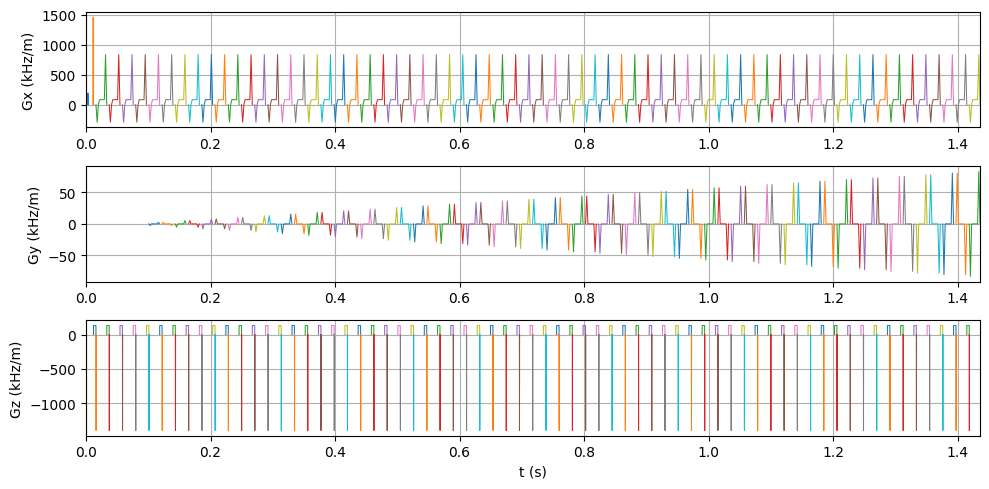

VoxelGridPhantom
size = tensor([0.2000, 0.2000, 0.0080])


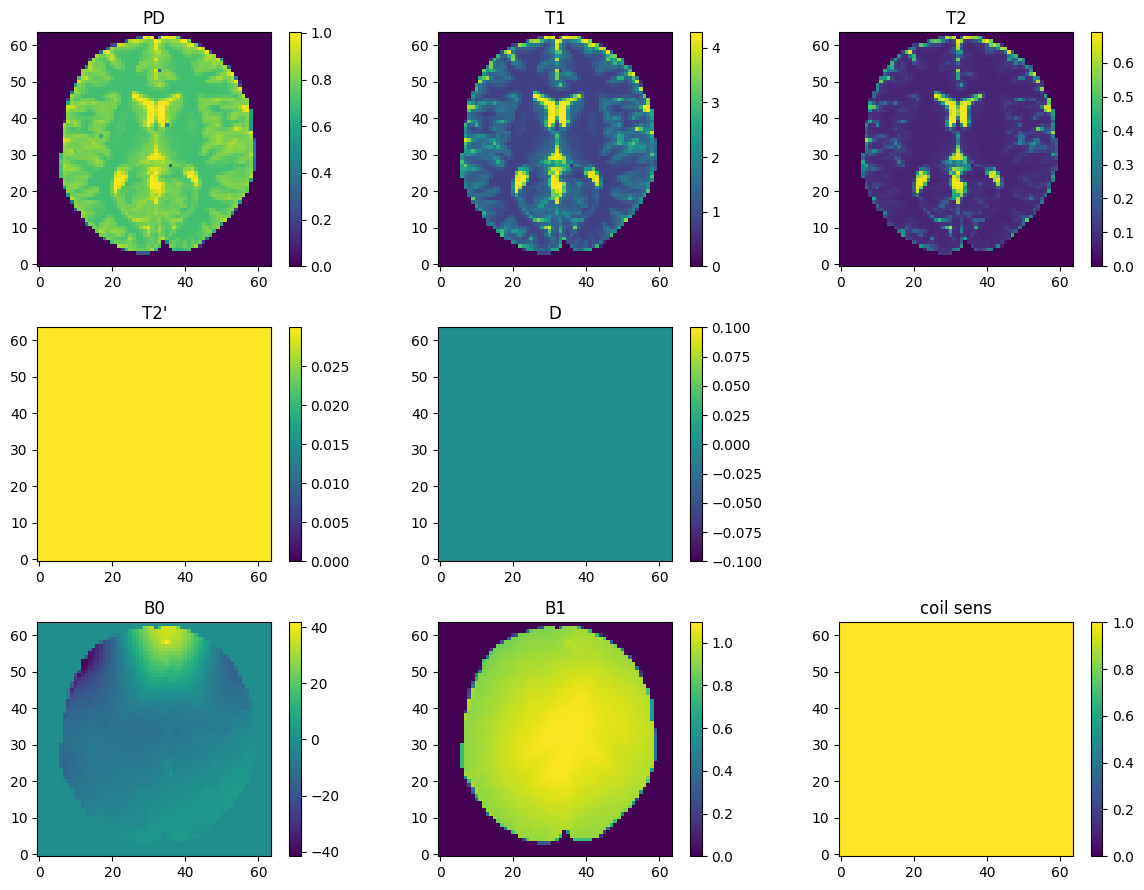

In [2]:
#@title generate
# %% S0. SETUP env
import MRzeroCore as mr0
import pypulseq as pp
import numpy as np
import torch
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

## import for masking
import matplotlib.image

## imports for image reconstruction
from skimage.restoration import unwrap_phase

## import for fitting
from scipy.stats import linregress

experiment_id = 'DREAM_STE'

# %% S1. SETUP sys
'''
# choose the scanner limits
system = pp.Opts(max_grad=28,grad_unit='mT/m',max_slew=150,slew_unit='T/m/s',
                 rf_ringdown_time=20e-6,rf_dead_time=100e-6,adc_dead_time=20e-6,grad_raster_time=50*10e-6)
'''

system = pp.Opts(
    max_grad=80,
    grad_unit='mT/m',
    max_slew=200,
    slew_unit='T/m/s',
    rf_ringdown_time=30e-6,
    rf_dead_time=100e-6,
    adc_dead_time=20e-6,
    grad_raster_time=10e-6
)

# %% S2. DEFINE the sequence
seq = pp.Sequence(system)

# Define FOV and resolution
fov = 200e-3
slice_thickness=8e-3
sz = (64, 64)  # spin system size / resolution
Nread = 64  # frequency encoding steps/samples
Nphase = 64  # phase encoding steps/samples
zoom = 1
ncoils = 20

# delay between STEAM preparation pulses, allows B0 mapping
timing_flag = False #True
delay = 5e-3

# Compute t0: smallest time interval [s] used in all events
bwd = 1000
dwell = np.round(2/(bwd*sz[0]), 5)/2
t0 = 64*2*dwell
print("Set bandwidth to " + str(1/(dwell*sz[0])) + "Hz/pixel")

#t1 = t0#*5 # t0 has to be converted for the extended gradients
gx_read_amp = (2*Nread*zoom)/(fov*4*t0) # amplitude for G_m (gx_read) part of gx_ext
gx_pre_amp = -7*gx_read_amp/2 # amplitude for G_m1 (gx_pre) part of gx_ext
# -> maybe change the timing system, so that t0 isn't used for everything and events can be timed better individually

# Define rf events
# STEAM rf pulses:
rf1 = pp.make_block_pulse(flip_angle=55 * np.pi / 180, duration=t0,system=system)
rf2 = pp.make_block_pulse(flip_angle=55 * np.pi / 180, phase_offset=180*np.pi/180, duration=t0, system=system)

rf1.delay = system.rf_dead_time
rf2.delay = system.rf_dead_time

# FLASH readout pulse and slice selction gradients:
rf3, gz3, gzr3 = pp.make_sinc_pulse(
    flip_angle=15 * np.pi/180,
    duration=2*t0,
    slice_thickness=slice_thickness,
    apodization=0.5,
    time_bw_product=4,
    system=system,
    return_gz=True
)


# Define other gradients and ADC events
gx_ext = pp.make_extended_trapezoid(channel='x', amplitudes=np.array([0,gx_pre_amp,0,gx_read_amp,gx_read_amp,10*gx_read_amp,0]), times=np.array([0,1*t0,2*t0,3*t0,7*t0,8*t0,9*t0]), system=system)
gx_m2 = pp.make_trapezoid(channel='x', area=gx_read_amp*2*t0, duration=t0-system.rf_ringdown_time, system=system)
gx_spoil = pp.make_trapezoid(channel='x', area=6*gx_read_amp*t0, duration=1e-3, system=system)
adc = pp.make_adc(num_samples=Nread*2, duration=4*t0, delay=3*t0, phase_offset=0*np.pi/180, system=system)

#dummies
dummies = 3

#rf spoiling
rf_phase = 0
rf_inc = 0
rf_spoiling_inc=84

#centric reordering
phase_enc__gradmoms = torch.arange(0,Nphase,1)-Nphase//2

permvec=np.zeros((Nphase,),dtype=int)
permvec[0]=0
for i in range(1,int(Nphase//2+1)):
    permvec[i*2-1]=-i
    if i <Nphase/2:
        permvec[i*2]=i
permvec+=Nphase//2
phase_enc__gradmoms=phase_enc__gradmoms[permvec]

# ======
# CONSTRUCT SEQUENCE
# ======

'''
# MP:
rf_prep, _= make_block_pulse(flip_angle=180 * math.pi / 180, duration=1e-3, system=system)
# FLAIR
seq.add_block(rf_prep)
seq.add_block(make_delay(2.7))
seq.add_block(gx_spoil)
'''
'''
# DIR
seq.add_block(rf_prep)
seq.add_block(make_delay(0.45))
seq.add_block(gx_spoil)
'''

#STEAM block
seq.add_block(rf1)
seq.add_block(gx_m2)

if timing_flag:
    seq.add_block(pp.make_delay(delay))

seq.add_block(rf2)
seq.add_block(gx_spoil)

#dummy block
for i in range(0, dummies):
    #rf spoiling
    rf3.phase_offset = rf_phase / 180 * np.pi   # set current rf phase
    adc.phase_offset = rf_phase / 180 * np.pi  # follow with ADC
    rf_inc = divmod(rf_inc + rf_spoiling_inc, 360.0)[1]   # increase increment
    rf_phase = divmod(rf_phase + rf_inc, 360.0)[1]        # increment additional pahse
    #dummies
    seq.add_block(rf3,gz3)
    seq.add_block(gx_ext,gzr3)

#readout block
rf3.phase_offset = rf_phase / 180 * np.pi   # set current rf phase
adc.phase_offset = rf_phase / 180 * np.pi  # follow with ADC

rf_inc = divmod(rf_inc + rf_spoiling_inc, 360.0)[1]   # increase increment
rf_phase = divmod(rf_phase + rf_inc, 360.0)[1]        # increment additional pahse

seq.add_block(rf3,gz3)
seq.add_block(gx_ext,gzr3,adc)

for ii in range(1, Nphase):
    #rf spoiling
    rf3.phase_offset = rf_phase / 180.0 * np.pi   # set current rf phase
    adc.phase_offset = rf_phase / 180.0 * np.pi  # follow with ADC
    rf_inc = divmod(rf_inc + rf_spoiling_inc, 360.0)[1]   # increase increment
    rf_phase = divmod(rf_phase + rf_inc, 360.0)[1]        # increment additional pahse

    gy_amp = (2*phase_enc__gradmoms[ii]*zoom)/(fov*2*t0) # set amplitude for y-gradients
    gy_ext = pp.make_extended_trapezoid(channel='y', amplitudes=np.array([0,gy_amp,0,0,-gy_amp,0]), times=np.array([0,1*t0,2*t0,7*t0,8*t0,9*t0]), system=system)
    seq.add_block(rf3,gz3)
    seq.add_block(gx_ext,gy_ext,gzr3,adc)

#seq.add_block(pp.make_delay(4)) # delay to ensure total relaxation of magnetization when measuring multiple sequences consecutively

# %% S3. CHECK, PLOT and WRITE the sequence  as .seq
ok, error_report = seq.check_timing()  # Check whether the timing of the sequence is correct
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]

# PLOT sequence
seq.plot()


# Prepare the sequence output for the scanner
seq.set_definition('FOV', [fov, fov, slice_thickness])
seq.set_definition('Name', 'gre')
seq.write(experiment_id +'.seq')

# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
sz = [64, 64]

if 1:
    # (i) load a phantom object from file
    obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
    obj_p = obj_p.interpolate(sz[0], sz[1], 1)
    # Manipulate loaded data
    obj_p.T2dash[:] = 30e-3
    obj_p.D *= 0
    obj_p.B0 *= 1    # alter the B0 inhomogeneity
    # Store PD for comparison
    PD = obj_p.PD
    B0 = obj_p.B0
    B1 = obj_p.B1
else:
    # or (ii) set phantom  manually to a pixel phantom. Coordinate system is [-0.5, 0.5]^3
    obj_p = mr0.CustomVoxelPhantom(
        pos=[[-0.4, -0.4, 0], [-0.4, -0.2, 0], [-0.3, -0.2, 0], [-0.2, -0.2, 0], [-0.1, -0.2, 0]],
        PD=[1.0, 1.0, 0.5, 0.5, 0.5],
        T1=1.0,
        T2=0.1,
        T2dash=0.1,
        D=0.0,
        B0=0,
        voxel_size=0.1,
        voxel_shape="box"
    )
    # Store PD for comparison
    PD = obj_p.generate_PD_map()
    B0 = torch.zeros_like(PD)

obj_p.plot()
# Convert Phantom into simulation data
obj_p = obj_p.build()

# change size and orientation of phantom data for later comparison
PD.resize_(64,64)
B0.resize_(64,64)
B1.resize_(64,64)

PD=np.flip(np.rot90(PD,3),1)
B0=np.flip(np.rot90(B0,3),1)
B1=np.flip(np.rot90(B1,3),1)


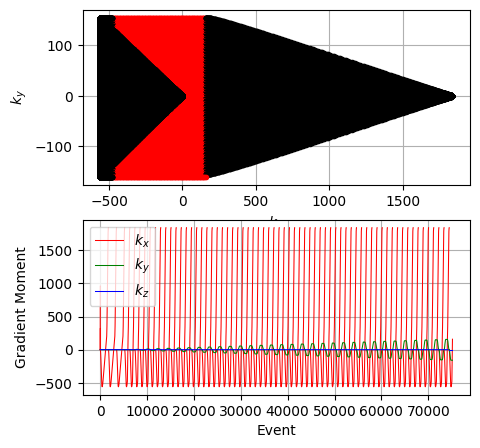

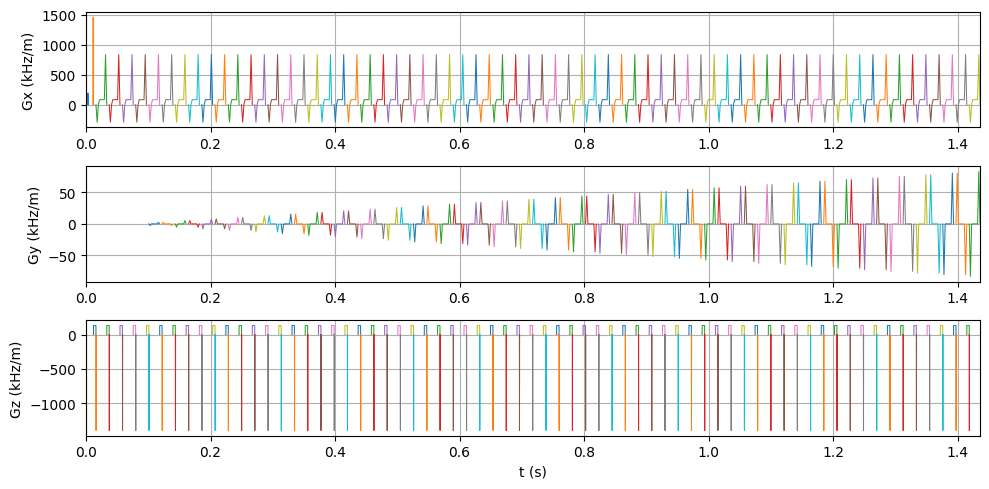

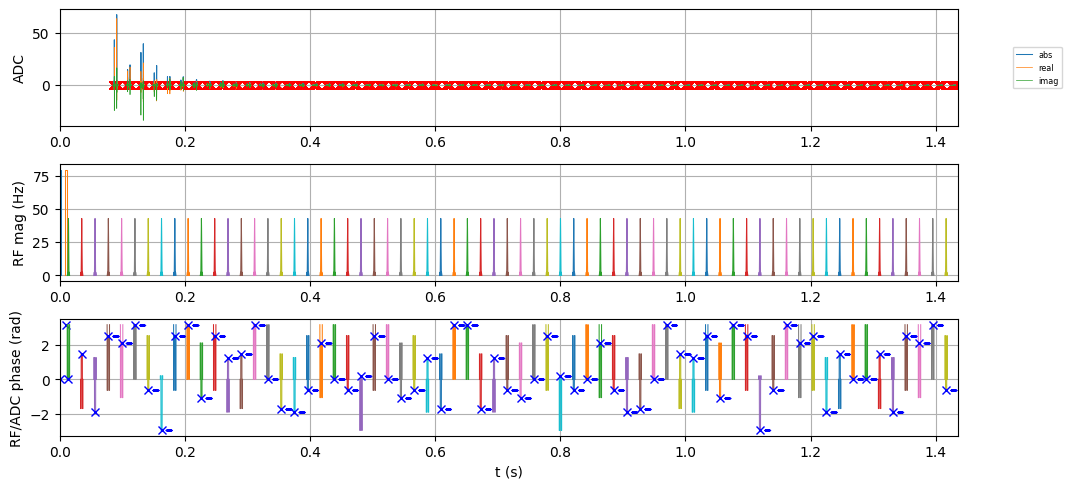

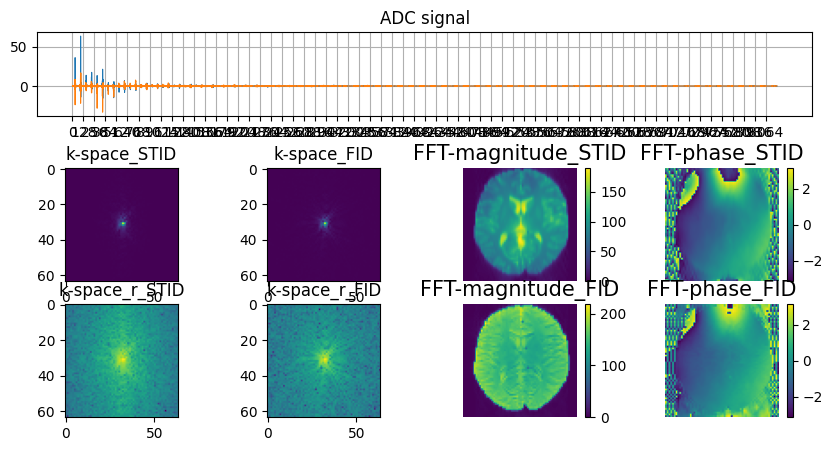

In [3]:
#@title simulate
# %% S5:. SIMULATE  the external.seq file and add acquired signal to ADC plot
seq0 = mr0.Sequence.import_file(experiment_id +'.seq')
# FIX: skip simulating z-gradients that the slice selection produces
for rep in seq0:
    rep.gradm[:, 2] = 0
seq0.plot_kspace_trajectory()
graph = mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal = mr0.execute_graph(graph, seq0, obj_p, print_progress=False)

seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()

# plot the result into the ADC subplot
#plt.close(11);plt.close(12)
#sp_adc, t_adc = mr0.util.pulseq_plot(seq, clear=False, signal=signal.numpy()) # doesn't work for invivo
#sp_adc.plot(t_adc,np.real(signal.numpy()),t_adc,np.imag(signal.numpy()))
#sp_adc.plot(t_adc,np.abs(signal.numpy()))
'''
# additional noise as simulation is perfect
z = 1e-5*np.random.randn(signal.shape[0], 2).view(np.complex128)
signal+=z
'''



# %% S6: MR IMAGE RECON of signal ::: #####################################

fig=plt.figure(); # fig.clf()
plt.subplot(411); plt.title('ADC signal')

plt.plot(torch.real(signal),label='real')
plt.plot(torch.imag(signal),label='imag')

major_ticks = np.arange(0, 2*Nphase*Nread, Nread*2) # this adds ticks at the correct position szread
ax=plt.gca(); ax.set_xticks(major_ticks); ax.grid()

spectrum=torch.reshape((signal),(Nphase,Nread*2)).clone().transpose(1,0)

# centric reordering
kspace_adc1=spectrum[0:Nread,:]
kspace_adc2=spectrum[Nread:,:]
ipermvec=np.arange(len(permvec))[np.argsort(permvec)]
kspace1=kspace_adc1[:,ipermvec]
kspace2=kspace_adc2[:,ipermvec]

#recon of first kspace
space1 = torch.zeros_like(kspace1)
# fftshift
kspace1_1=torch.fft.fftshift(kspace1,0); kspace1_1=torch.fft.fftshift(kspace1_1,1)
#FFT
space1 = torch.fft.fft2(kspace1_1,dim=(0,1))
# fftshift
space1=torch.fft.ifftshift(space1,0); space1=torch.fft.ifftshift(space1,1)

img_STE = space1

#recon of second kspace
space2 = torch.zeros_like(kspace2)
# fftshift
kspace2_1=torch.fft.fftshift(kspace2,0); kspace2_1=torch.fft.fftshift(kspace2_1,1)
#FFT
space2 = torch.fft.fft2(kspace2_1,dim=(0,1))
# fftshift
space2=torch.fft.ifftshift(space2,0); space2=torch.fft.ifftshift(space2,1)

img_FID = space2

img_STE = np.flip(np.rot90(img_STE,3),1)

img_FID = np.flip(np.rot90(img_FID,3),1)

plt.subplot(345); plt.title('k-space_STID')
plt.imshow(np.abs(kspace1))
plt.subplot(349); plt.title('k-space_r_STID')
plt.imshow(np.log(np.abs(kspace1)))

plt.subplot(346); plt.title('k-space_FID')
plt.imshow(np.abs(kspace2))
plt.subplot(3,4,10); plt.title('k-space_r_FID')
plt.imshow(np.log(np.abs(kspace2)))

plt.subplot(347); plt.title('FFT-magnitude_STID', fontsize=15)
plt.imshow(np.abs(img_STE),vmin=0,origin='lower'); plt.axis('off'); plt.colorbar()
plt.subplot(3,4,11); plt.title('FFT-magnitude_FID', fontsize=15)
plt.imshow(np.abs(img_FID),vmin=0,origin='lower'); plt.axis('off'); plt.colorbar()

plt.subplot(348); plt.title('FFT-phase_STID', fontsize=15)
plt.imshow(np.angle(img_STE),vmin=-np.pi,vmax=np.pi,origin='lower'); plt.axis('off'); plt.colorbar()
plt.subplot(3,4,12); plt.title('FFT-phase_FID', fontsize=15)
plt.imshow(np.angle(img_FID),vmin=-np.pi,vmax=np.pi,origin='lower'); plt.axis('off'); plt.colorbar()


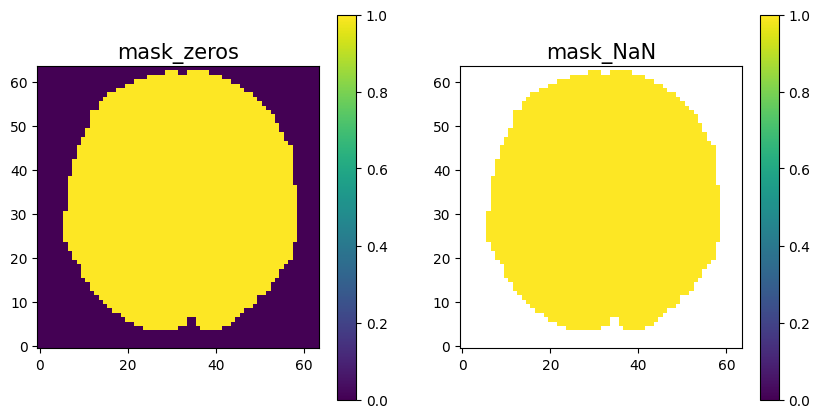

In [4]:
#@title masking
# %% S7: MASKING

# choose wether or not to use a mask
masking = 1
if masking:
    # function for threshold masking
    def mask_im(input_array, threshold, mask_values):
        mask = np.ones_like(input_array)
        mask[input_array<threshold] = mask_values
        return mask

    mask_zero = mask_im(np.abs(B1), 0.7, 0)
    mask_NaN = mask_im(np.abs(B1), 0.7, np.NaN)

else:
    mask_zero = np.ones_like(B1)
    mask_NaN = np.ones_like(B1)

# plot mask with zeros and NaNs (zero mask is used for further calculations, NaN mask is used when showing the images)
fig=plt.figure();
plt.subplot(121); plt.title('mask_zeros', fontsize=15)
plt.imshow(mask_zero, vmin=0, vmax=1, origin='lower'); plt.colorbar()

plt.subplot(122); plt.title('mask_NaN', fontsize=15)
plt.imshow(mask_NaN, vmin=0, vmax=1, origin='lower'); plt.colorbar()


"\nfig=plt.figure();\nplt.subplot(); plt.title(''$\\Phi_{txrx}$' phase unwrapped [rad]', fontsize=15)\ntxrx_unwrap = unwrap_phase(txrx_phase*mask_zero)\nplt.imshow(txrx_unwrap*mask_NaN,vmin=-2*np.pi,vmax=2*np.pi, origin='lower'); plt.axis('off'); plt.colorbar()\n#if unwrap starts in the wrong area and makes everything negative:\n#plt.imshow((txrx_unwrap-np.min(txrx_unwrap)-np.pi)*mask_NaN,vmin=0,vmax=3*np.pi, origin='lower'); plt.axis('off'); plt.colorbar()\n"

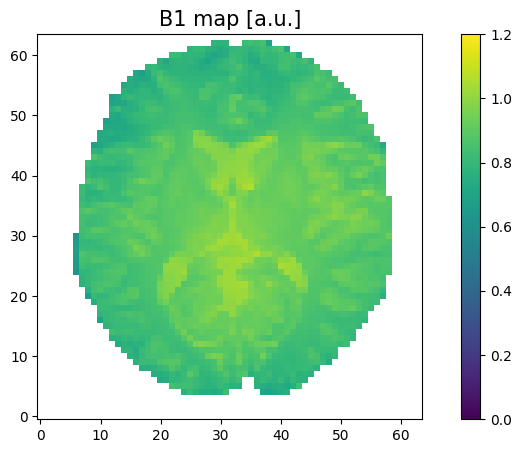

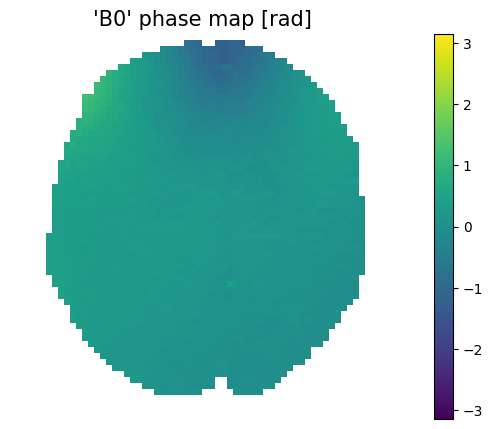

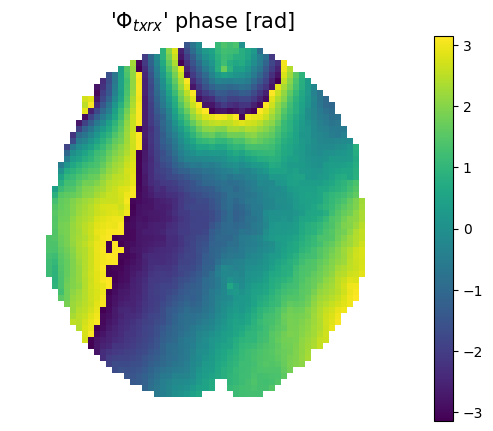

In [5]:
#@title B1, B0, txrx
# %% S8: STEAM flip angle / B1 map
fig=plt.figure();
plt.subplot(); plt.title('B1 map [a.u.]', fontsize=15)
B1_angle = np.arctan(np.sqrt(2*(np.abs(img_STE))/(np.abs(img_FID))))*(180/np.pi)/55
plt.imshow(B1_angle*mask_NaN, vmin=0, vmax=1.2, origin='lower'); plt.colorbar() # 0 to 1.2 when comparing to WASABI  # 0 to 1.09 for simulation

# %% S9: 'B0' maps
# for the STID timing, its not possible to create a B0 map; section is called 'B0' because it uses the formula that generates a B0 map when using the STE timing
fig=plt.figure();
plt.subplot(); plt.title('\'B0\' phase map [rad]', fontsize=15)
B0_phase = np.angle(img_FID*np.conjugate(img_STE))
plt.imshow(B0_phase*mask_NaN,vmin=-np.pi,vmax=np.pi, origin='lower'); plt.axis('off'); plt.colorbar()
'''
# unwrapping may be unnecessary here
fig=plt.figure();
plt.subplot(); plt.title('\'B0\' phase map unwrapped [rad]', fontsize=15)
B0_unwrap = unwrap_phase(B0_phase*mask_zero)
plt.imshow(B0_unwrap*mask_NaN,vmin=-np.pi,vmax=np.pi, origin='lower'); plt.colorbar()
'''
# %% S10: 'transceive chain' maps
# for the STID timing, its not possible to create a txrx map; section is called 'txrx' because it uses the formula that generates a txrx map when using the STE timing
fig=plt.figure();
plt.subplot(); plt.title('\'$\Phi_{txrx}$\' phase [rad]', fontsize=15)
txrx_phase = np.angle(img_FID*img_STE)
plt.imshow(txrx_phase*mask_NaN,vmin=-np.pi,vmax=np.pi, origin='lower'); plt.axis('off'); plt.colorbar()
'''
fig=plt.figure();
plt.subplot(); plt.title('\'$\Phi_{txrx}$\' phase unwrapped [rad]', fontsize=15)
txrx_unwrap = unwrap_phase(txrx_phase*mask_zero)
plt.imshow(txrx_unwrap*mask_NaN,vmin=-2*np.pi,vmax=2*np.pi, origin='lower'); plt.axis('off'); plt.colorbar()
#if unwrap starts in the wrong area and makes everything negative:
#plt.imshow((txrx_unwrap-np.min(txrx_unwrap)-np.pi)*mask_NaN,vmin=0,vmax=3*np.pi, origin='lower'); plt.axis('off'); plt.colorbar()
'''

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


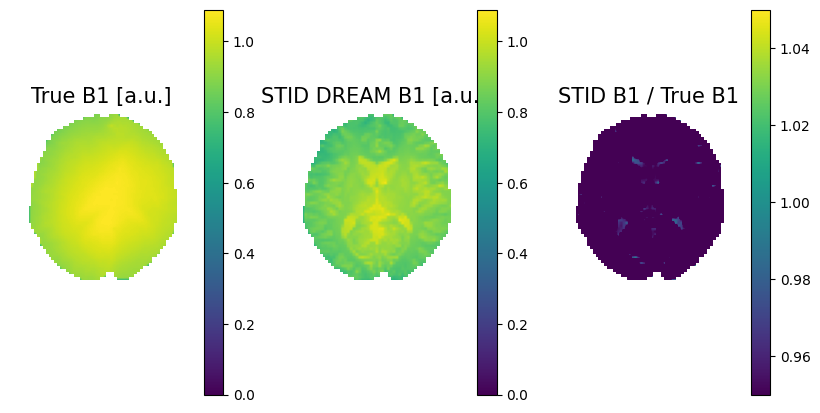

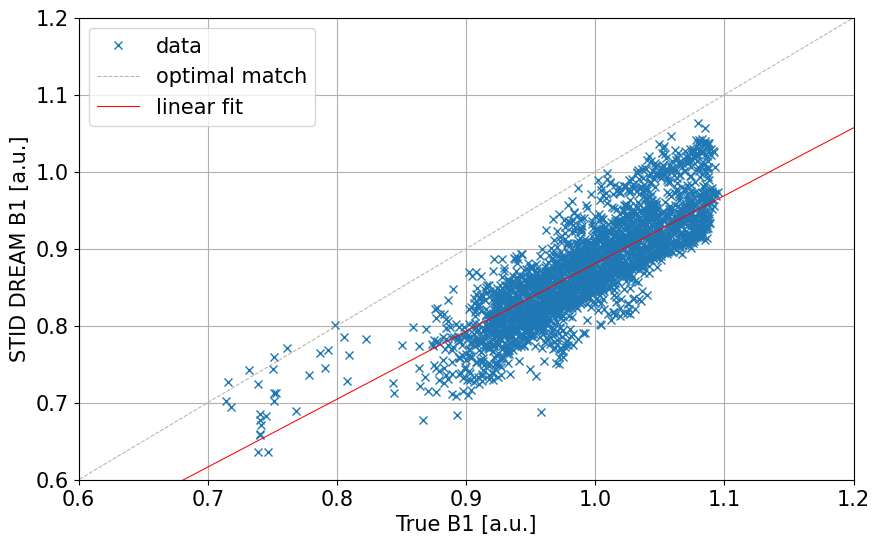

In [6]:
#@title compare DREAM and simulation phantom
# %% S11: compare DREAM simulation to simulation phantom

fig=plt.figure();
#B1 map simulation phantom
plt.subplot(131); plt.title('True B1 [a.u.]', fontsize=15)
plt.imshow(np.abs(B1)*mask_NaN, vmin=0, vmax=1.09, origin="lower")
plt.axis('off')
plt.colorbar()

#B1 map STID simulation
plt.subplot(132); plt.title('STID DREAM B1 [a.u.]', fontsize=15)
plt.imshow(B1_angle*mask_NaN, vmin=0 ,vmax=1.09, origin='lower')
plt.axis('off')
plt.colorbar()
'''
#B1 diff map
plt.subplot(143); plt.title('B1 diff map (DREAM-phantom)', fontsize=15)
plt.imshow(-(B1-(B1_angle*mask_NaN)), vmin=-0.05, vmax=0.05, origin="lower")
plt.colorbar()
'''
#B1 ratio map
plt.subplot(133); plt.title('STID B1 / True B1', fontsize=15)
plt.imshow((B1_angle*mask_NaN)/np.abs(B1), vmin=0.95, vmax=1.05, origin="lower")
plt.axis('off')
plt.colorbar()


#B1 scatter plot
fig=plt.figure(figsize=(10,6));
plt.subplot(111); #plt.title('B1 comparison', fontsize=15)
n = np.linspace(0, 1.2, 121)
slope1, intercept1, _, _, _ = linregress(np.reshape(B1*mask_zero,4096),np.reshape((np.abs(B1_angle)*mask_zero),4096))
plt.ylabel('STID DREAM B1 [a.u.]', fontsize=15)
plt.xlabel('True B1 [a.u.]', fontsize=15)
plt.xlim(0.6,1.2)
plt.ylim(0.6,1.2)
plt.grid()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot(np.reshape(B1,4096),np.reshape((B1_angle*mask_NaN),4096),'x', label='data')
plt.plot(n, n, color='0.7', linestyle='--', label='optimal match')
plt.plot(n, slope1*n+intercept1, 'r', label='linear fit')
plt.legend(fontsize=15)
